# <h1 align= 'center'>Base Models</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. 
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)


> **Here, we use basic regression and classification models to establish baseline performance metrics.**

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from scipy.stats import uniform
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

## <h2> <center>Load preprocessed data</center></h2>

In [10]:
#read from local dataset
movies = pd.read_csv('/Users/mohitkapoor/Downloads/New code/cleaned_data.csv')
movies.sample(7)

,Unnamed: 0,review,sentiment
4360,4360,realli love read book chapter leav want get th...,1
46532,46532,wow come anoth straight video scarecrow keep c...,0
46013,46013,think time seagal go quiet night seen make dir...,0
3103,3103,know rest viewer person dead sick tire steven ...,0
2378,2378,okay admit right front inki cartoon made looni...,1
40185,40185,alway great admir nicola roeg walkabout favori...,1
27869,27869,watch odd littl adventur hard believ direct ma...,1


## <h2> <center>Text feature extraction</center></h2>

In [11]:
# todo: normalize if overfit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


top_k = 15000

tfidf = TfidfVectorizer(
                    ngram_range = (1,2),
                    dtype = 'int32',
                    decode_error = 'replace',
                    analyzer = 'word',
                    min_df = 2,
                    norm = 'l2'
                    )
tfidf_reviews = tfidf.fit_transform(movies['review'])

# Select best 10,000(k) features, with feature importance measured by f_classif
selector = SelectKBest(f_classif, k = min(top_k, tfidf_reviews.shape[1]))
selector.fit(tfidf_reviews, movies['sentiment'])
vect_reviews = selector.transform(tfidf_reviews).astype('float32')

vect_reviews.shape

(50000, 15000)

## <h2> <center>Split the data</center></h2>

In [12]:
X = vect_reviews.toarray()
y = (np.array(movies['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (40000, 15000), 
Test dataset shape: (10000, 15000)


In [13]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names  = ['Positive', 'Negative'], vmax=None,
                           normalized=True, title='Confusion matrix'):
    """
    Helper fuction to generate a clean Confusion Matrix using seaborn library.
    y_true: True labels, y_pred: Model Predictions, class_names: Override if needed
    normalized: True, gives the proportions instead of absolute numbers
    """
    matrix = confusion_matrix(y_true,y_pred)
    if normalized:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    annot_kws = {'fontsize':25, 
                'fontstyle': 'italic'}
    sns.heatmap(matrix, vmax=vmax, annot=True,  annot_kws = annot_kws,
                square=True, ax=ax, cbar=False,
                cmap=sns.diverging_palette(20, 250, as_cmap=True), 
                linecolor='black', linewidths=0.5,
                xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

## <h2> <center>Modeling the data</center></h2>

### <h2> <center>Base Logistic Regression model</center></h2>

In [6]:
lr=LogisticRegression(max_iter=500 ,random_state=7, 
                      C = 10, penalty = 'l2') # found from Random Search 
lr.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=500, random_state=7)

In [7]:
pred = lr.predict(X_test)
pred_train = lr.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  93.8175
Test set Accuracy:  90.79


Accuracy: 0.9079
Precision: 0.9080243747054727
Recall: 0.9079
F1 Score: 0.9078902443074963
Confusion Matrix:
[[4480  505]
 [ 416 4599]]


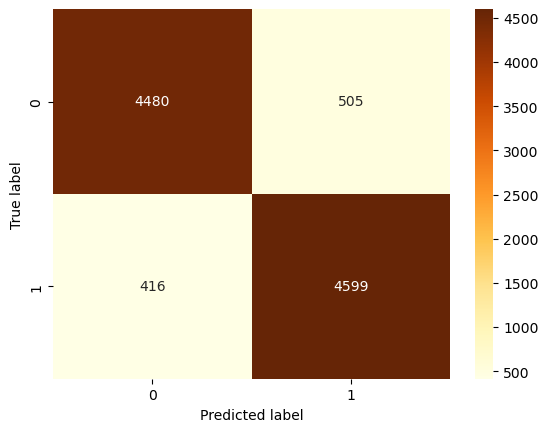

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=lr.classes_, yticklabels=lr.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

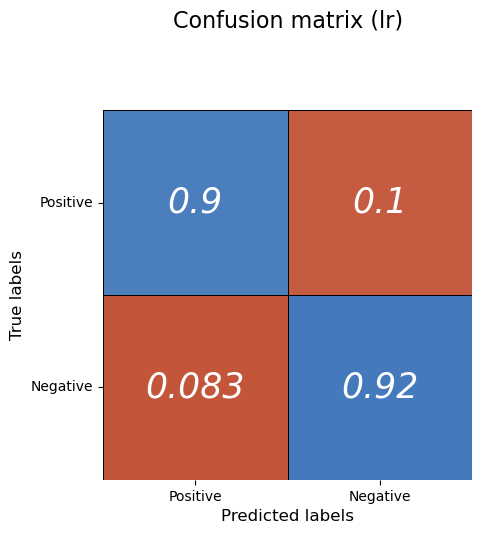

In [14]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (lr)')

In [25]:
penalty = ['l2', 'l1']
# Create regularization hyperparameter distribution using uniform distribution
C = [0.1, 10, 100]
logistic = LogisticRegression()
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
pprint(hyperparameters)
lr_best = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy',
                       cv = 2, verbose = 0, refit=True, return_train_score = True)

{'C': [0.1, 10, 100], 'penalty': ['l2', 'l1']}


In [26]:
lr_best.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 10, 100], 'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='accuracy')

In [27]:
lr_best_penalty = lr_best.best_estimator_.get_params()['penalty']
lr_best_c = lr_best.best_estimator_.get_params()['C']
print(f'Best Penalty: {lr_best_penalty}')
print(f'Best C: {lr_best_c}')

pprint(lr_best.best_params_)

Best Penalty: l2
Best C: 10
{'C': 10, 'penalty': 'l2'}


In [28]:
pred = lr_best.predict(X_test)
pred_train = lr_best.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  93.8175
Test set Accuracy:  90.79


Accuracy: 0.9079
Precision: 0.9080243747054727
Recall: 0.9079
F1 Score: 0.9078902443074963
Confusion Matrix:
[[4480  505]
 [ 416 4599]]


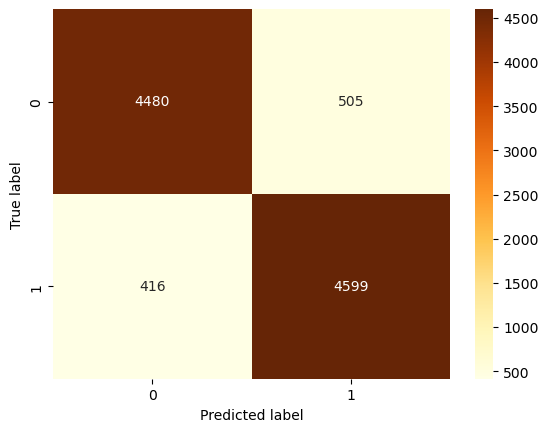

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = lr_best.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=lr_best.classes_, yticklabels=lr_best.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

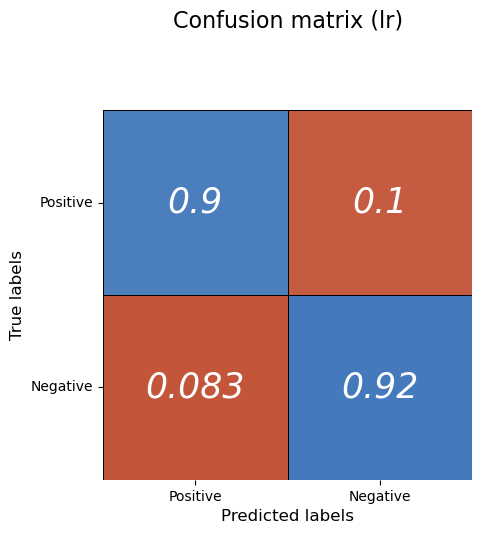

In [21]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (lr)')

### <h2> <center>SVM Classifier</center></h2>

In [22]:
svm = SGDClassifier(random_state = 7, penalty = 'l2', loss = 'hinge')

svm.fit(X_train,y_train)

SGDClassifier(random_state=7)

In [23]:
pred = svm.predict(X_test)
pred_train = svm.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  89.885
Test set Accuracy:  89.08


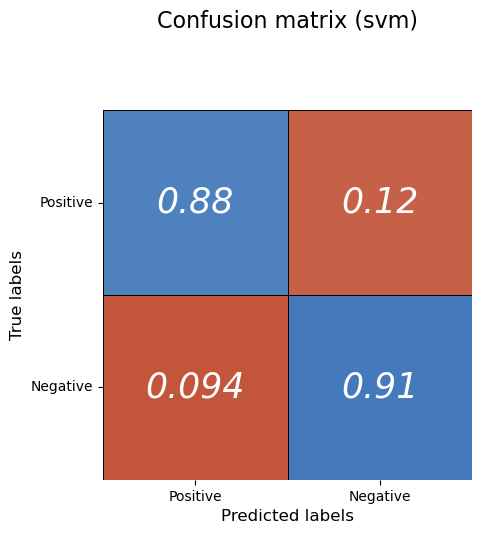

In [24]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svm)',
                       class_names=['Positive', 'Negative'])

Accuracy: 0.8908
Precision: 0.8911515949132214
Recall: 0.8908
F1 Score: 0.890769780902226
Confusion Matrix:
[[4363  622]
 [ 470 4545]]


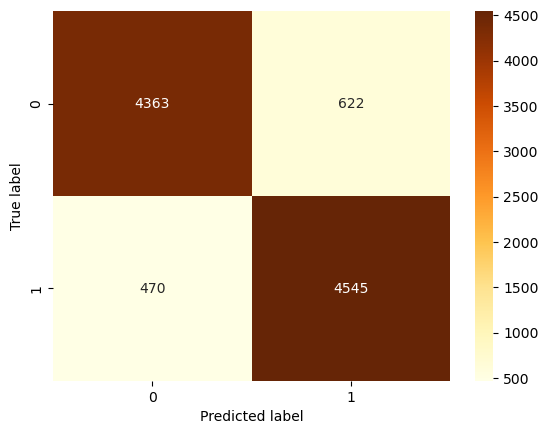

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=svm.classes_, yticklabels=svm.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

### <h2> <center>Linear SVC</center></h2>

In [41]:
svc = LinearSVC(random_state = 7)
svc.fit(X_train, y_train)

LinearSVC(random_state=7)

In [42]:
pred = svc.predict(X_test)
pred_train = svc.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  94.0725
Test set Accuracy:  91.03999999999999


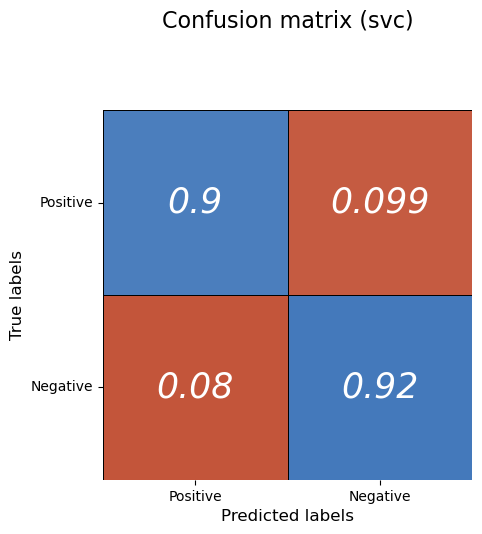

In [28]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svc)',
                       class_names=['Positive', 'Negative'])

Accuracy: 0.9104
Precision: 0.9105340604983457
Recall: 0.9104
F1 Score: 0.9103899417989374
Confusion Matrix:
[[4491  494]
 [ 402 4613]]


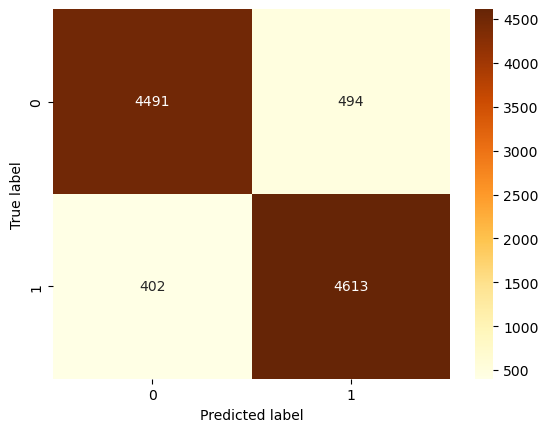

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=svc.classes_, yticklabels=svc.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

In [30]:
losses = ["hinge", "squared_hinge"]
duals = [False, True]
learning_rates = [1e-1, 1, 10]
penalties = ["l1", "l2"]

hyperparam = {
    "C": learning_rates,
    "penalty": penalties,
    "loss": losses,
    "dual": duals
    }
pprint(hyperparam)
svc = LinearSVC()

n_iter = 50
svc_random = RandomizedSearchCV(svc, hyperparam, cv=2, scoring = 'accuracy',
                                verbose=0, refit = True)

{'C': [0.1, 1, 10],
 'dual': [False, True],
 'loss': ['hinge', 'squared_hinge'],
 'penalty': ['l1', 'l2']}


In [31]:
svc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=LinearSVC(),
                   param_distributions={'C': [0.1, 1, 10],
                                        'dual': [False, True],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'penalty': ['l1', 'l2']},
                   scoring='accuracy')

In [33]:
pprint(svc_random.best_params_)

{'C': 1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [34]:
pred = svc_random.predict(X_test)
pred_train = svc_random.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  94.0725
Test set Accuracy:  91.03999999999999


Accuracy: 0.9104
Precision: 0.9105340604983457
Recall: 0.9104
F1 Score: 0.9103899417989374
Confusion Matrix:
[[4491  494]
 [ 402 4613]]


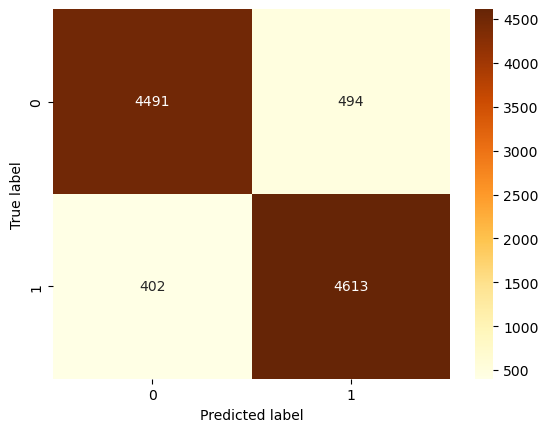

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = svc_random.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=svc_random.classes_, yticklabels=svc_random.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

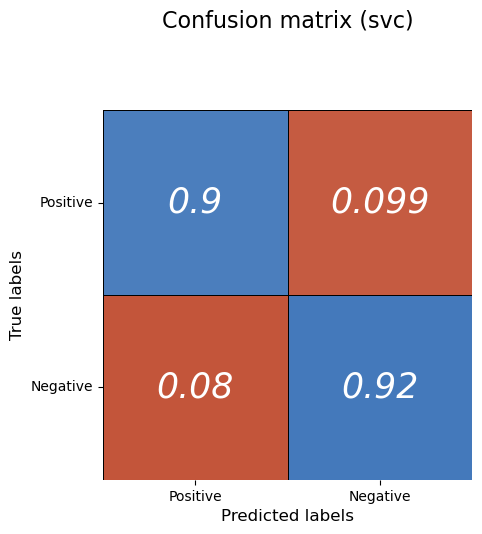

In [44]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svc)',
                       class_names=['Positive', 'Negative'])

### <h2> <center>Multinomial Bayes Classifier</center></h2>

In [7]:
from sklearn.naive_bayes import MultinomialNB


In [14]:
#training the model
mnb = MultinomialNB(alpha = 0.001) # best alpha found from Grid Search
#fitting the svm for bag of words
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

In [15]:
pred = mnb.predict(X_test)
pred_train = mnb.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  92.41749999999999
Test set Accuracy:  91.27


Accuracy: 0.9127
Precision: 0.9127543858406745
Recall: 0.9127
F1 Score: 0.9126954155138628
Confusion Matrix:
[[4519  466]
 [ 407 4608]]


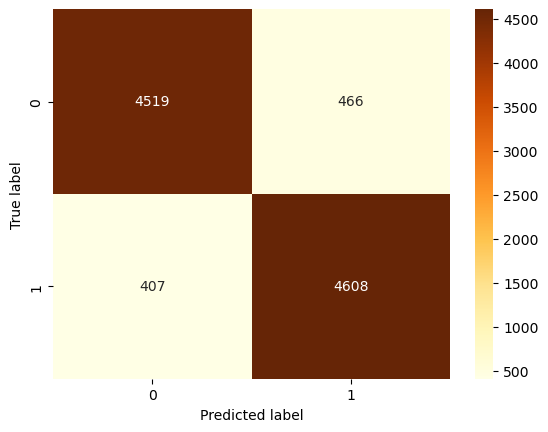

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = mnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=mnb.classes_, yticklabels=mnb.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

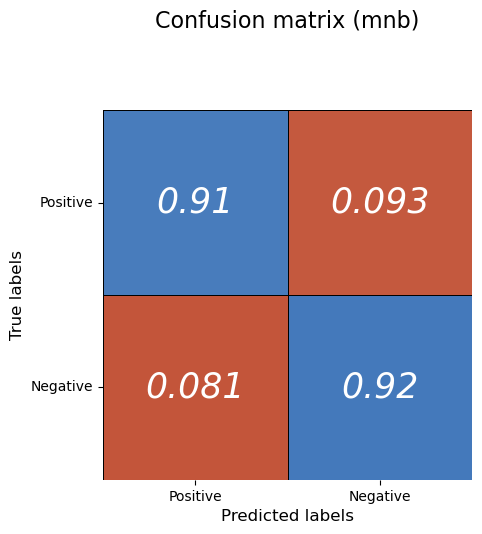

In [49]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (mnb)')

In [17]:
alpha =  [0.001, 0.003, 0.1, 0.3, 1]
hyperparam = dict(alpha = alpha)
mnb_best = GridSearchCV(mnb, hyperparam, scoring = 'accuracy', cv = 2, refit = True, verbose = 1, return_train_score = True)
pprint(hyperparam)

{'alpha': [0.001, 0.003, 0.1, 0.3, 1]}


In [18]:
mnb_best.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


GridSearchCV(cv=2, estimator=MultinomialNB(alpha=0.001),
             param_grid={'alpha': [0.001, 0.003, 0.1, 0.3, 1]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [19]:
mnb_best_alpha = mnb_best.best_estimator_.get_params()['alpha']
print(f'Best alpha: {mnb_best_alpha}')

Best alpha: 0.001


In [20]:
pred = mnb_best.predict(X_test)
pred_train = mnb_best.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  92.41749999999999
Test set Accuracy:  91.27


Accuracy: 0.9127
Precision: 0.9127543858406745
Recall: 0.9127
F1 Score: 0.9126954155138628
Confusion Matrix:
[[4519  466]
 [ 407 4608]]


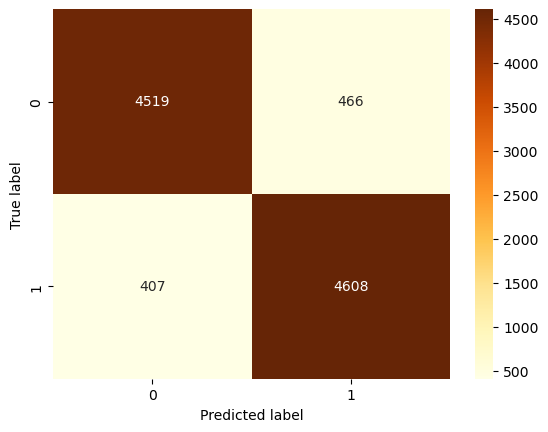

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = mnb_best.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=mnb_best.classes_, yticklabels=mnb_best.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

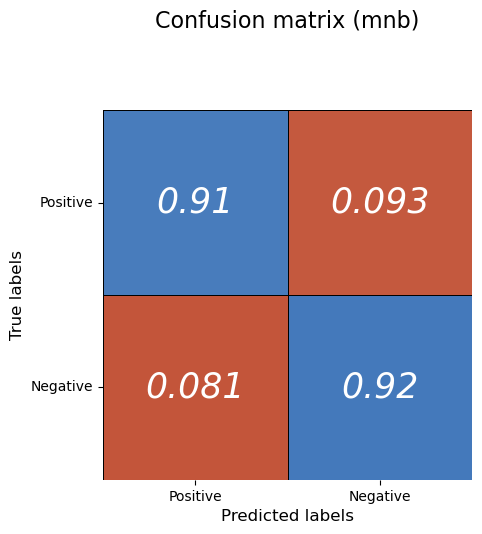

In [23]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (mnb)')

### <h2> <center>Random Forest Classifier</center></h2>

In [56]:
rf = RandomForestClassifier(max_depth = 100, 
                            n_estimators = 500,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            max_features = 'sqrt',
                            random_state = 7)  # found from Random Search

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_leaf=5, n_estimators=500,
                       random_state=7)

In [57]:
pred = rf.predict(X_test)
pred_train = rf.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  95.11749999999999
Test set Accuracy:  86.09


Accuracy: 0.8609
Precision: 0.86101714984143
Recall: 0.8609
F1 Score: 0.8608840859433625
Confusion Matrix:
[[4243  742]
 [ 649 4366]]


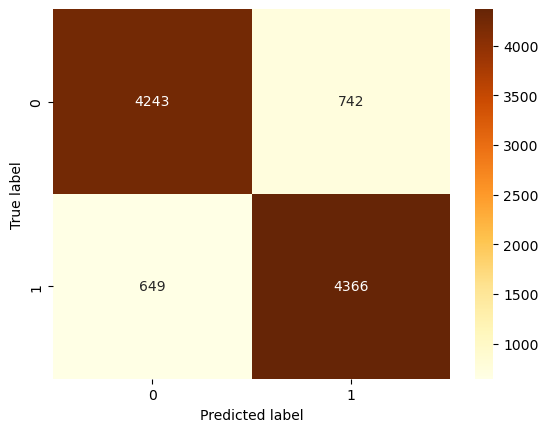

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=rf.classes_, yticklabels=rf.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

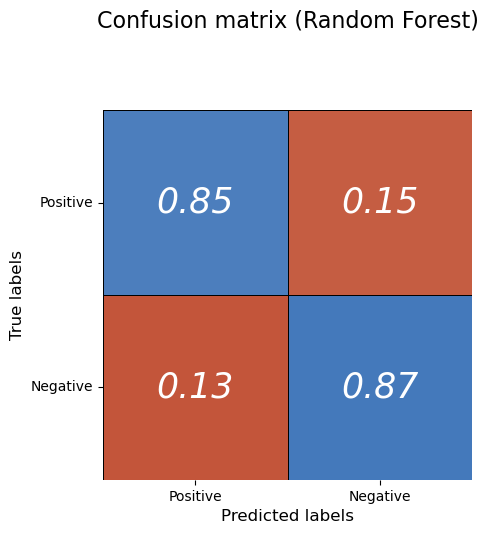

In [59]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (Random Forest)',
                       class_names=['Positive', 'Negative'])

In [60]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(hyperparam)
rf_temp = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf_temp, hyperparam, cv = 2, n_iter = 10, verbose = 1,
                        refit = False, return_train_score = True)

{'max_depth': [10, 55, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 550, 1000]}


In [61]:
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 55, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 550, 1000]},
                   refit=False, return_train_score=True, verbose=1)

In [41]:
pprint(rf_random.best_params_)

{'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}


* The models that performed the best Multinomial Naive Bayes and Support Vector Machine
* Random forest seems to be overfitting and is obviously not suited to this task.